In [1]:
# -*- coding: utf8

from scipy import stats as ss

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize']  = (18, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [4]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

# Aula 23 - Aprendizado na Prática

Nesta aula vamos explorar aprendizado de máquina na prática. Em particular, vamos iniciar por algoritmos de classificação na base Fashion MNIST. Depois disso vamos explorar regressão.

## Classificação

Acima, temos alguns códigos auxiliares para carregar a base. Nesta, cada ponto é um vetor de 784 posições. Ao redimensionar os mesmos com:

```python
x.reshape((28, 28))
```

Temos uma imagem de alguma peça de vestimento. Código para carregar os dados abaixo. Vamos usar apenas 500 instâncias para treino e teste. Lento usar muito mais do que isso no meu computador.

In [5]:
X_train, y_train = load_mnist('fashion', kind='train')
X_test, y_test = load_mnist('fashion', kind='t10k')

In [6]:
X_train = X_train[:500]
y_train = y_train[:500]

X_test = X_test[:500]
y_test = y_test[:500]

In [7]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([53, 40, 63, 46, 55, 52, 49, 52, 43, 47]))

Observe como cada instância é um vetor. Cada valor é um tom de cinza. 0 == branco; 256 == preto.

In [8]:
X_train[10]

array([  0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 162, 167,  84,
        30,  38,  94, 177, 176,  26,   0,   0,   0,   1,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   0,   0,  41, 147, 228, 242, 228,
       236, 251, 251, 251, 255, 242, 230, 247, 221, 125,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  91, 216, 228, 222,
       219, 219, 218, 222, 200, 224, 230, 221, 222, 222, 227, 237, 183,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4, 202, 208,
       212, 217, 219, 222, 222, 219, 219, 220, 218, 222, 224, 224, 221,
       210, 227, 163,   0,   0,   0,   0,   0,   0,   0,   0,   0, 102,
       225, 210, 216, 218, 222, 221, 219, 225, 225, 221, 222, 224, 222,
       224, 224, 215, 215, 218,  28,   0,   0,   0,   0,   0,   0,   0,
         0, 189, 222, 220, 213, 219, 220, 218, 221, 220, 219, 222, 226,
       222, 220, 221, 216, 215, 218, 229, 148,   0,   0,   0,   0,   0,
         0,   0,  11, 240, 210, 227, 213, 214, 220, 217, 220, 22

Ao redimensionar temos uma peça de roupa! Fashion!

In [9]:
I = X_train[0].reshape(28, 28)
print(I.shape)

(28, 28)


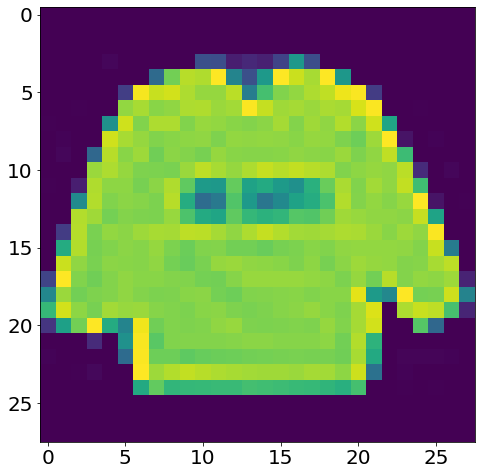

In [10]:
plt.imshow(X_train[0].reshape(28, 28))

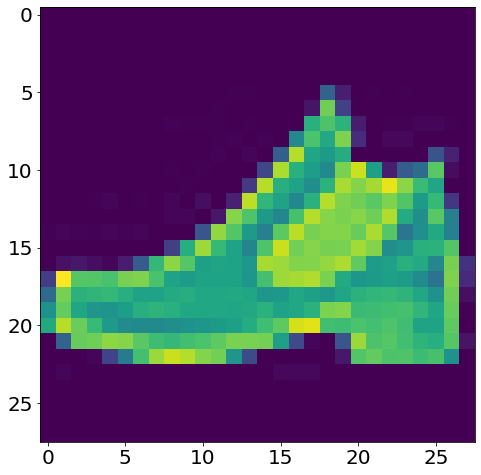

In [11]:
plt.imshow(X_train[1].reshape(28, 28))

In [12]:
M = np.array([[1, 2], [2, 3]])
M.ravel()

array([1, 2, 2, 3])

Temos 10 classes. 

In [13]:
len(set(y_train))

10

In [14]:
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
index = np.arange(len(text_labels))
labels = pd.Series(text_labels, index=index)
labels

0       t-shirt
1       trouser
2      pullover
3         dress
4          coat
5        sandal
6         shirt
7       sneaker
8           bag
9    ankle boot
dtype: object

## Executando o Scikit-Learn

Agora, vamos executar o código do sklearn na nossa base. Lembrando que temos que separar a mesma em Treino, Validação e Teste. Para tal, vamos fazer uso da classe `StratifiedKFold`. A mesma serve para realizar n-fold cross validation. A biblioteca sklearn não cria grupos de validação para você, a mesma só usa o conceito de treino/teste. De qualquer forma, validação nada mais é do que um conjunto a mais de teste. Então, vamos fazer 5-fold no nosso treino, separando em treino/validação. Note que NUNCA avaliamos nada no teste, apenas reportamos os números no fim!!

In [15]:
from sklearn.model_selection import StratifiedKFold

Ao gerar o split, tereos 20 conjuntos (muito eu sei).

In [16]:
skf = StratifiedKFold(n_splits=20, shuffle=True)

Cada passo do laço retorna indices do vetor

In [17]:
for treino, validacao in skf.split(X_train, y_train):
    count_train = np.unique(y_train[validacao], return_counts=True)
    break

Vamos quebrar nos conjuntos e avaliar o KNN. De um mundo de métricas, vamos fazer uso de 4 neste notebook:

1. Precisão
2. Revocação
3. F1
4. Acurácia

![](./f.png)

Na figura acima, assuma que o termo `busca` indica as previsões do seu classificador (sem tempo para alterar a figura irmão). Sendo `y_p (y-pred)` um conjunto de elementos da previsão e `y_t (y-true)` os rótulos reais. Por clareza, vamos assumir duas classes `1 e 0`. Afinal, o caso multiclasse pode ser reduzido para este. Assim, cada elemento dos vetores `y_p` e `y_t` $\in \{0, 1\}$. Os verdadeiros positivos, __true positive (TP)__, é o conjunto de previsões da classe `1` que foram corretas. Podemos formalizar como:

$$TP = \sum_i \mathbb{1}_{y_t[i] = 1} \mathbb{1}_{y_p[i] = 1}$$

$\mathbb{1}_{y_t[i] = 1}$ retorna 1 quando $y_t[i] = 1$, 0 caso contrário. O mesmo vale para $\mathbb{1}_{y_t[i] = y_p[i]}$ que retorna um quando $y_p[i] = 1$. Usando a mesma notação, os verdadeiros negativos é definido como:

$$TN = \sum_i \mathbb{1}_{y_t[i] = 0} \mathbb{1}_{y_t[i] = 0}$$

Os falsos positivos e negativos capturam os erros da previsão. Note que nos dois a previsão é o oposto do real:

$$FP = \sum_i \mathbb{1}_{y_t[i] = 0} \mathbb{1}_{y_p[i] = 1}$$

$$FN = \sum_i \mathbb{1}_{y_t[i] = 1} \mathbb{1}_{y_p[i] = 0}$$

Assim, a acurácia do classificador é definida como a fração total de acertos:

$$Acuracia = \frac{TP + TN}{TP + TN + FP + FN}$$

A precisão é definida como a fração dos elementos classificados como 1 que foram corretos:

$$Precisão = \frac{TP}{TP + FP}$$

A revocação é a fração de todos os elementos do conjunto 1 que foram acertados. Diferente da precisão, aqui focamos nos elementos reais! Na precisão focamos nas previsões.

$$Revocação = \frac{TP}{TP + FN}$$

Tanto a previsão quanto a revocação importam. Na primeira, precisão, queremos saber o quão bom o classificador é em retornar acertos. Na segunda, o quanto de elementos reais o classificador captura. Observe como um classificador que sempre retorna 1 tem revocação máxima, porém precisão baixa. Um classificador que sempre retorna 0 tem precisão máxima e revocação baixa. Para captura a média harmônica dos dois usamos o F1-score:

$$F1 = MediaHarmonica(Precisao, Revocacao)$$

Dependendo do problema uma métrica pode importar mais do que a outra. Aqui, trabalhamos com classes balanceadas, então a acurácia já é boa suficiente. Vamos avaliar a acurácia nos conjuntos abaixo:

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Observe como o laço abaixo guarda o melhor valor de n para cada fold de validação!

In [19]:
fold = 0
melhores = []
for treino, validacao in skf.split(X_train, y_train):
    X_tt = X_train[treino]
    y_tt = y_train[treino]
    X_v = X_train[validacao]
    y_v = y_train[validacao]
    
    best = (0, 0)
    for nn in [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100]: # Vamos testar tais valores de n
        model = KNeighborsClassifier(n_neighbors=nn)
        model.fit(X_tt, y_tt) # treina no conjunto de treino
        y_pv = model.predict(X_v) # previsões no conjunto de validação
        
        # Resultado com melhor acurácia!
        accuracy = accuracy_score(y_v, y_pv)
        if accuracy > best[0]:
            best = (accuracy, nn)
    
    melhores.append(best[1])
    fold += 1
    print('Fold-{}, melhor n = {}, acc = {}'.format(fold, best[1], best[0]))

Fold-1, melhor n = 2, acc = 0.8
Fold-2, melhor n = 2, acc = 0.72
Fold-3, melhor n = 20, acc = 0.84
Fold-4, melhor n = 3, acc = 0.64
Fold-5, melhor n = 3, acc = 0.76
Fold-6, melhor n = 8, acc = 0.8
Fold-7, melhor n = 2, acc = 0.76
Fold-8, melhor n = 5, acc = 0.72
Fold-9, melhor n = 2, acc = 0.68
Fold-10, melhor n = 6, acc = 0.76
Fold-11, melhor n = 4, acc = 0.8
Fold-12, melhor n = 3, acc = 0.76
Fold-13, melhor n = 6, acc = 0.88
Fold-14, melhor n = 3, acc = 0.84
Fold-15, melhor n = 5, acc = 0.8
Fold-16, melhor n = 7, acc = 0.76
Fold-17, melhor n = 20, acc = 0.76
Fold-18, melhor n = 50, acc = 0.8
Fold-19, melhor n = 2, acc = 0.84
Fold-20, melhor n = 5, acc = 0.68


Vamos ver quantas vezes cada escolha de número de vizinhos, nn, ganhou na validação.

Text(0, 0.5, 'Count na validação')

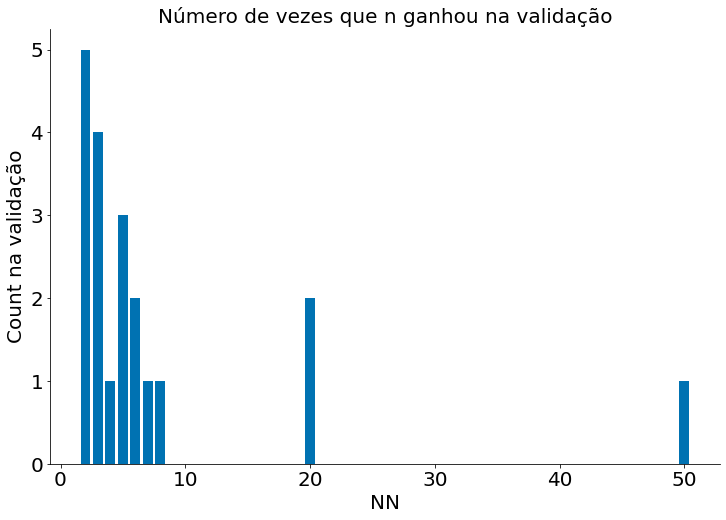

In [20]:
unique, counts = np.unique(melhores, return_counts=True)
plt.bar(unique, counts)
despine()
plt.title('Número de vezes que n ganhou na validação')
plt.xlabel('NN')
plt.ylabel('Count na validação')

Agora, podemos finalmente avaliar o modelo no conjunto de teste! Vamos escolher n como a médiana dos folds.

In [21]:
print(np.median(melhores))

4.5


Vamos verificar as outras métricas e todas as classes.

In [22]:
from sklearn.metrics import classification_report

model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        53
           1       0.97      0.97      0.97        40
           2       0.52      0.54      0.53        63
           3       0.75      0.91      0.82        46
           4       0.58      0.56      0.57        55
           5       0.94      0.56      0.70        52
           6       0.45      0.41      0.43        49
           7       0.68      0.87      0.76        52
           8       0.97      0.79      0.87        43
           9       0.83      0.94      0.88        47

    accuracy                           0.72       500
   macro avg       0.74      0.73      0.73       500
weighted avg       0.73      0.72      0.71       500



Parece que erramos muito a classe 4, coat. Casacos se parecem com camisas, vestidos etc. Podemos investigar isto usando a matriz de confusão.

([<matplotlib.axis.YTick at 0x7f621f5cb2b0>,
 [Text(0, 0, 't-shirt'),
  Text(0, 0, 'trouser'),
  Text(0, 0, 'pullover'),
  Text(0, 0, 'dress'),
  Text(0, 0, 'coat'),
  Text(0, 0, 'sandal'),
  Text(0, 0, 'shirt'),
  Text(0, 0, 'sneaker'),
  Text(0, 0, 'bag'),
  Text(0, 0, 'ankle boot')])

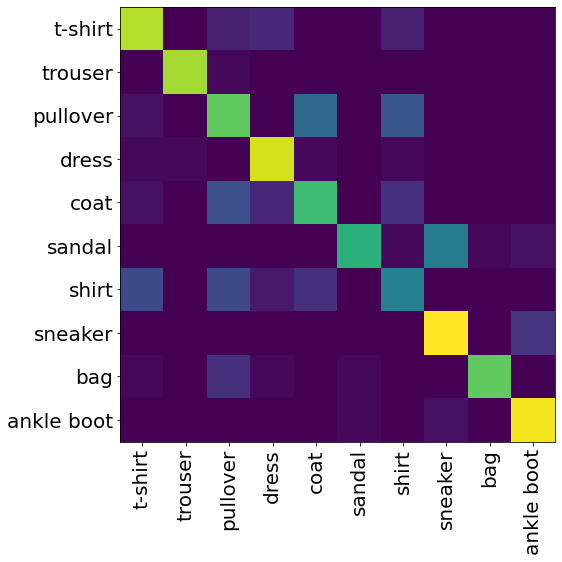

In [23]:
from sklearn.metrics import confusion_matrix
plt.imshow(confusion_matrix(y_test, model.predict(X_test)))
plt.xticks(labels.index, labels, rotation=90)
plt.yticks(labels.index, labels)

## Logística

Vamos repetir tudo para a regressão logística. Felizmente, o sklearn tem uma versão da logística que já faz treino/validação internamente. Para alguns modelos, existem atalhos para fazer isto. Caso queira entender, leia:

https://robjhyndman.com/hyndsight/crossvalidation/

In [24]:
from sklearn.linear_model import LogisticRegressionCV

In [25]:
# O LogisticCV tenta várias regularizações.
model = LogisticRegressionCV(Cs=100,
                             penalty='l2',   #ridge
                             cv=5,           #5 folds internos
                             fit_intercept=False,
                             multi_class='ovr')
model.fit(X_train, y_train)

/home/ptcar/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ptcar/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
 

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
                     fit_intercept=False, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [26]:
model.C_

array([1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.55567614e+03])

In [27]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.64      0.72        53
           1       1.00      0.97      0.99        40
           2       0.69      0.54      0.61        63
           3       0.75      0.91      0.82        46
           4       0.59      0.75      0.66        55
           5       1.00      0.69      0.82        52
           6       0.52      0.65      0.58        49
           7       0.84      0.88      0.86        52
           8       0.89      0.79      0.84        43
           9       0.85      0.98      0.91        47

    accuracy                           0.77       500
   macro avg       0.80      0.78      0.78       500
weighted avg       0.79      0.77      0.77       500



([<matplotlib.axis.YTick at 0x7f621f507370>,
 [Text(0, 0, 't-shirt'),
  Text(0, 0, 'trouser'),
  Text(0, 0, 'pullover'),
  Text(0, 0, 'dress'),
  Text(0, 0, 'coat'),
  Text(0, 0, 'sandal'),
  Text(0, 0, 'shirt'),
  Text(0, 0, 'sneaker'),
  Text(0, 0, 'bag'),
  Text(0, 0, 'ankle boot')])

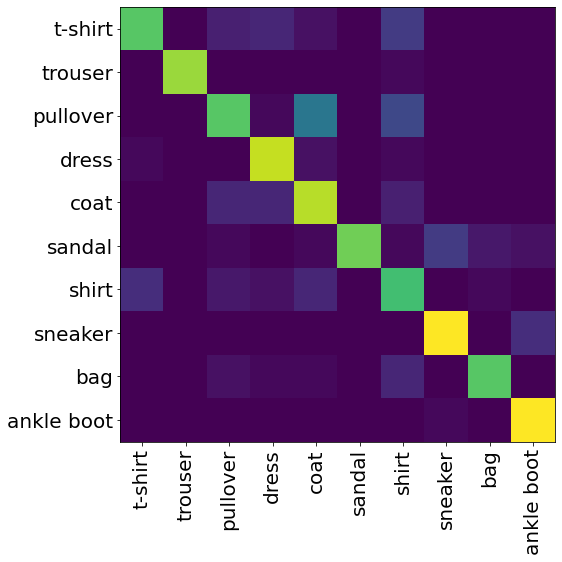

In [28]:
plt.imshow(confusion_matrix(y_test, model.predict(X_test)))
plt.xticks(labels.index, labels, rotation=90)
plt.yticks(labels.index, labels)

## Lebron James

Agora vamos avalias os modelos em dados tabulares. Primeiro, vamos carregar os dados. Obsevre que cada atributo é diferente. Data, numéricos categóricos, etc...

In [29]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/23-MLPratica/lebron.csv')
df.head()

,game_date,minute,opponent,action_type,shot_type,shot_distance,shot_made
0,20170415,10,IND,Driving Layup Shot,2PT Field Goal,0,0
1,20170415,11,IND,Driving Layup Shot,2PT Field Goal,0,1
2,20170415,14,IND,Layup Shot,2PT Field Goal,0,1
3,20170415,15,IND,Driving Layup Shot,2PT Field Goal,0,1
4,20170415,18,IND,Alley Oop Dunk Shot,2PT Field Goal,0,1


Primeiro temos que converter os atributos categóricos em colunas novas. Para isto, fazemos uso de one hot encoding. Cada categoria vira uma coluna de 1/0. Algoritmos como KNN e Logistic não sabem fazer uso de categorias por padrão. Mesmo se as categorias representarem números, faça uso de one hot. Sempre se pergunte: faz sentido computar uma distância nessa coluna? Se não, one-hot (ou outra abordagem).

In [30]:
df = pd.get_dummies(df, columns=['opponent', 'action_type', 'shot_type'])
df.head()

,game_date,minute,shot_distance,shot_made,opponent_BOS,opponent_GSW,opponent_IND,opponent_TOR,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,...,action_type_Running Pull-Up Jump Shot,action_type_Running Reverse Layup Shot,action_type_Step Back Jump shot,action_type_Tip Layup Shot,action_type_Turnaround Fadeaway Bank Jump Shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Hook Shot,action_type_Turnaround Jump Shot,shot_type_2PT Field Goal,shot_type_3PT Field Goal
0,20170415,10,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,20170415,11,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,20170415,14,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20170415,15,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,20170415,18,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [31]:
df.shape

(384, 44)

Agora vamos converter a data. Note que a mesma existe em uma escala completamente diferente do resto.

In [32]:
datas = pd.to_datetime(df['game_date'], format='%Y%m%d')
datas

0     2017-04-15
1     2017-04-15
2     2017-04-15
3     2017-04-15
4     2017-04-15
         ...    
379   2017-06-12
380   2017-06-12
381   2017-06-12
382   2017-06-12
383   2017-06-12
Name: game_date, Length: 384, dtype: datetime64[ns]

Como trabalhar com esse mundo de valores distintos? Solução!? Normalizar!

In [33]:
df['game_date'] = np.array(datas, dtype='d') # nano segundos, valores gigantes, vamos normalizar
df.head()

,game_date,minute,shot_distance,shot_made,opponent_BOS,opponent_GSW,opponent_IND,opponent_TOR,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,...,action_type_Running Pull-Up Jump Shot,action_type_Running Reverse Layup Shot,action_type_Step Back Jump shot,action_type_Tip Layup Shot,action_type_Turnaround Fadeaway Bank Jump Shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Hook Shot,action_type_Turnaround Jump Shot,shot_type_2PT Field Goal,shot_type_3PT Field Goal
0,1.492214e+18,10,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.492214e+18,11,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.492214e+18,14,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.492214e+18,15,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1.492214e+18,18,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Vamos criar nosso treino e teste.

In [34]:
copy = df.copy()
y = copy['shot_made']
del copy['shot_made']
X = copy

In [35]:
X_train = X[:200]
y_train = y[:200]

X_test = X[200:]
y_test = y[200:]

Existe uma classe no sklearn que normaliza dados.

**IMPORTANTE SÓ NORMALIZE O TREINO!!! DEPOIS USE A MÉDIA E DESVIO DO TREINO PARA NORMALIZAR O TESTE!!**

**O TESTE É UM FUTURO! NÃO EXISTE, VOCÊ NÃO SABE NADA DO MESMO**

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_new_train = scaler.fit_transform(X_train)

In [37]:
X_new_train

array([[-1.3241922 , -1.07998356, -1.01672335, ..., -0.20412415,
         0.61588176, -0.61588176],
       [-1.3241922 , -1.00649029, -1.01672335, ..., -0.20412415,
         0.61588176, -0.61588176],
       [-1.3241922 , -0.78601049, -1.01672335, ..., -0.20412415,
         0.61588176, -0.61588176],
       ...,
       [ 1.80999052, -0.71251722, -0.92121153, ..., -0.20412415,
         0.61588176, -0.61588176],
       [ 1.80999052, -0.63902396,  0.98902492, ..., -0.20412415,
         0.61588176, -0.61588176],
       [ 1.80999052, -0.56553069,  1.08453674, ..., -0.20412415,
        -1.62368828,  1.62368828]])

Vamos fazer penalização l1, lasso. A mesma tende a zerar os fatores não importantes.

In [38]:
model = LogisticRegressionCV(Cs=100, fit_intercept=True,
                             cv=3,
                             multi_class='ovr',
                             penalty='l1',
                             solver='liblinear')
model.fit(X_new_train, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=3, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=None, penalty='l1',
                     random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

Ao executar o scaler no teste usamos a média e desvio do treino para converter.

In [39]:
(X_test - X_train.mean()) / X_train.std(ddof=1)

,game_date,minute,shot_distance,opponent_BOS,opponent_GSW,opponent_IND,opponent_TOR,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Cutting Dunk Shot,...,action_type_Running Pull-Up Jump Shot,action_type_Running Reverse Layup Shot,action_type_Step Back Jump shot,action_type_Tip Layup Shot,action_type_Turnaround Fadeaway Bank Jump Shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Hook Shot,action_type_Turnaround Jump Shot,shot_type_2PT Field Goal,shot_type_3PT Field Goal
200,1.805460,-0.490806,1.367640,2.243948,NaN,-0.920648,-0.772658,-0.100252,-0.070711,NaN,...,-0.100252,NaN,-0.203613,-0.070711,-0.070711,-0.252013,-0.070711,-0.203613,-1.619624,1.619624
201,1.805460,-0.417496,0.796004,2.243948,NaN,-0.920648,-0.772658,-0.100252,-0.070711,NaN,...,-0.100252,NaN,-0.203613,-0.070711,-0.070711,3.948206,-0.070711,-0.203613,0.614340,-0.614340
202,1.805460,-0.344187,-0.061451,2.243948,NaN,-0.920648,-0.772658,-0.100252,-0.070711,NaN,...,-0.100252,NaN,-0.203613,-0.070711,-0.070711,-0.252013,-0.070711,-0.203613,0.614340,-0.614340
203,1.805460,-0.270878,-0.823633,2.243948,NaN,-0.920648,-0.772658,-0.100252,-0.070711,NaN,...,-0.100252,NaN,-0.203613,-0.070711,-0.070711,-0.252013,-0.070711,-0.203613,0.614340,-0.614340
204,1.805460,-0.124259,-0.728360,2.243948,NaN,-0.920648,-0.772658,-0.100252,-0.070711,NaN,...,-0.100252,NaN,-0.203613,-0.070711,-0.070711,-0.252013,14.071425,-0.203613,0.614340,-0.614340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,4.012286,1.415236,-0.918906,-0.443415,inf,-0.920648,-0.772658,-0.100252,-0.070711,NaN,...,-0.100252,NaN,-0.203613,-0.070711,-0.070711,-0.252013,-0.070711,-0.203613,0.614340,-0.614340
380,4.012286,1.488545,-0.918906,-0.443415,inf,-0.920648,-0.772658,-0.100252,-0.070711,NaN,...,-0.100252,NaN,-0.203613,-0.070711,-0.070711,-0.252013,-0.070711,-0.203613,0.614340,-0.614340
381,4.012286,1.561855,-0.918906,-0.443415,inf,-0.920648,-0.772658,-0.100252,-0.070711,NaN,...,-0.100252,NaN,-0.203613,-0.070711,-0.070711,-0.252013,-0.070711,-0.203613,0.614340,-0.614340
382,4.012286,1.635164,0.319640,-0.443415,inf,-0.920648,-0.772658,-0.100252,-0.070711,NaN,...,-0.100252,NaN,-0.203613,-0.070711,-0.070711,3.948206,-0.070711,-0.203613,0.614340,-0.614340


In [40]:
X_test_new = scaler.transform(X_test)
print(classification_report(y_test, model.predict(X_test_new)))

              precision    recall  f1-score   support

           0       0.64      0.57      0.61        80
           1       0.70      0.75      0.72       104

    accuracy                           0.67       184
   macro avg       0.67      0.66      0.66       184
weighted avg       0.67      0.67      0.67       184



Um fator interessante da logística é que o sinal do coeficiente pode ser interpretado. Quanto mais perto, mais chance de marcar uma cesta (peso negativo, menor disância leva para 1). Quando o lance é um `action_type_Fadeaway Jump Shot -0.20025856688`, maior chance de errar! No `action_type_Running Dunk Shot 0.118529302866` maior chance de acertar.

In [41]:
for i, col in enumerate(copy.columns):
    print(col, model.coef_[0][i])

game_date 0.0
minute 0.0
shot_distance -0.32543026910624007
opponent_BOS 0.0
opponent_GSW 0.0
opponent_IND 0.0
opponent_TOR 0.0
action_type_Alley Oop Dunk Shot 0.0
action_type_Alley Oop Layup shot 0.0
action_type_Cutting Dunk Shot 0.0
action_type_Cutting Finger Roll Layup Shot 0.015255990761724037
action_type_Cutting Layup Shot 0.0
action_type_Driving Bank shot 0.0
action_type_Driving Dunk Shot 0.04017103856304328
action_type_Driving Finger Roll Layup Shot 0.08468124487031582
action_type_Driving Floating Bank Jump Shot 0.0
action_type_Driving Floating Jump Shot 0.0
action_type_Driving Hook Shot 0.0
action_type_Driving Layup Shot 0.0
action_type_Driving Reverse Layup Shot 0.0
action_type_Dunk Shot 0.0
action_type_Fadeaway Jump Shot -0.20025636430780444
action_type_Floating Jump shot -0.03850335693354805
action_type_Jump Bank Shot 0.0
action_type_Jump Shot 0.0
action_type_Layup Shot 0.0
action_type_No Shot 0.0
action_type_Pullup Jump shot 0.1494500600836877
action_type_Putback Layup Shot